In [1]:
import pathlib
import skimage
import cv2
import numpy as np
import pandas as pd
from skimage import feature
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from sklearn import preprocessing
import math
%matplotlib inline  

In [2]:
im_dir = pathlib.Path('F:/device/optics/32w_Realtime_test_5th/2')

In [3]:
temp_li = ['Low Temp', 'High Temp']
x_range = slice(400, 1900)
y_range = slice(400, 1900)
colors_li = [plt.cm.get_cmap('hsv', 30)(i) for i in range(30)]

In [4]:
ch_dict = {
    0: 'CalRed',
    1: 'FAM',
    2: 'Q670',
    3: 'HEX'
}

In [ ]:
im_dict = {}
for ch in range(4):
    ch_name = ch_dict[ch]
    im_dict[ch_name] = {}
    for t in range(2):
        im_dict[ch_name][temp_li[t]] = {}
        for c in range(45):
            im_dict[ch_name][temp_li[t]][c] = {}
            fpath = im_dir/f'{c}_{t}_{ch}.jpg'
            im = np.array(Image.open(fpath))
            im_cropped = im[x_range, y_range]

            im_int = im_cropped[:, :, 0] + im_cropped[:, :, 1] + im_cropped[:, :, 2]
            im_hsv = cv2.cvtColor(im_cropped, cv2.COLOR_BGR2HSV)
            im_val = im_hsv[:, :, 2]

            thresh = skimage.filters.threshold_otsu(im_int)
            threshed_im1 = im_int > thresh
            im_dict[ch_name][temp_li[t]][c]['int_otsu'] = {'threshed': threshed_im1}
            
            thresh = skimage.filters.threshold_mean(im_int)
            threshed_im2 = im_int > thresh
            im_dict[ch_name][temp_li[t]][c]['int_mean'] = {'threshed': threshed_im2}
            
            thresh = skimage.filters.threshold_triangle(im_int)
            threshed_im3 = im_int > thresh
            im_dict[ch_name][temp_li[t]][c]['int_triangle'] = {'threshed': threshed_im3}
            
            thresh = skimage.filters.threshold_otsu(im_val)
            threshed_im4 = im_val > thresh
            im_dict[ch_name][temp_li[t]][c]['val_otsu'] = {'threshed': threshed_im4}
            
            thresh = skimage.filters.threshold_mean(im_val)
            threshed_im5 = im_val > thresh
            im_dict[ch_name][temp_li[t]][c]['val_mean'] = {'threshed': threshed_im5}
            
            thresh = skimage.filters.threshold_triangle(im_val)
            threshed_im6 = im_val > thresh
            im_dict[ch_name][temp_li[t]][c]['val_triangle'] = {'threshed': threshed_im6}
            
            for type in im_dict[ch_name][temp_li[t]][c].keys():
                threshed_im = im_dict[ch_name][temp_li[t]][c][type]['threshed']
                bw = skimage.morphology.closing(threshed_im, skimage.morphology.disk(3))
                bw2 = skimage.morphology.opening(bw, skimage.morphology.disk(3))
                cleared = skimage.segmentation.clear_border(bw2)
                im_labeled = skimage.measure.label(cleared)
                im_dict[ch_name][temp_li[t]][c][type]['labeled'] = im_labeled

                region_raw_dict = {}
                if 'int' in type:
                    _im = im_int
                else:
                    _im = im_val
                for region in skimage.measure.regionprops(im_labeled, intensity_image=_im):
                    region_raw_dict[region.area] = region
                im_dict[ch_name][temp_li[t]][c][type]['regions'] = region_raw_dict
        

In [ ]:
type_li = ['int_otsu', 'int_mean', 'int_triangle', 'val_otsu', 'val_mean', 'val_triangle']

In [ ]:
result_dict = {}
for type in type_li:
    result_dict[type] = {}
    for temp in temp_li:
        result_dict[type][temp] = {}
        for ch in ch_dict.values():
            result_dict[type][temp][ch] = {}

In [ ]:
row = list('ABCD')[::-1]
result_dict = {}
box_li = []
for ch in ch_dict.values():
    for temp in temp_li:
        regions = im_dict[ch][temp][44]['val_otsu']['regions']
        
        areas_li = []
        for area, region in regions.items():
            areas_li.append(area)
            
        sorted_region_key = list(areas_li)
        sorted_region_key.sort(reverse=True)
        
        minr_li = []
        minc_li = []
        maxr_li = []
        maxc_li = []
        for key in sorted_region_key[:16]:
            region = regions[key]
            minr, minc, maxr, maxc = region.bbox
            minr_li.append(minr)
            minc_li.append(minc)
            maxr_li.append(maxr)
            maxc_li.append(maxc)
        minr_li.sort()
        top = minr_li[0]
        minc_li.sort()
        left = minc_li[0]
        maxr_li.sort()
        bottom = maxr_li[-1]
        maxc_li.sort()
        right = maxc_li[-1]
        box_li.append([top, left, bottom, right])

box_arr = np.array(box_li)
top = box_arr[:, 0].mean()
left = box_arr[:, 1].mean()
bottom = box_arr[:, 2].mean()
right = box_arr[:, 3].mean()

well_box = [top-50, left-50, bottom+50, right+50]
y_li = np.linspace(well_box[0], well_box[2], 5, endpoint=True)
x_li = np.linspace(well_box[1], well_box[3], 5, endpoint=True)
pts_x = []
pts_y = []
for x in x_li:
    for y in y_li:
        pts_x.append(x)
        pts_y.append(y)
pts_li = list(zip(pts_x, pts_y))

i = 0
well_location_dict = {}
for x in range(4):
    for y in range(4):
        key = row[y]+str(x+1)
        top_left_pt = pts_li[i+y+x]
        bottom_right_pt = pts_li[i+y+x+6]
        well_location_dict[key] = [top_left_pt[1], top_left_pt[0], bottom_right_pt[1], bottom_right_pt[0]]
    i += 4
result_dict['well_grid'] = well_location_dict
        
            

In [ ]:
result_dict['well_grid']

In [ ]:
def get_well_loc(x, y, pts_center, well_location_dict):
    for well in well_location_dict.keys():
        y_min, x_min, y_max, x_max = well_location_dict[well]
        if y_min < y < y_max and x_min < x < x_max:
            radius = (x_max-x_min)/2 - 50
            pts_given = np.array([x, y])
            distance = np.linalg.norm(pts_given-pts_center)
            if distance < radius:
                return well

In [ ]:
def get_grid_loc(x, y, well_location_dict):
    for well in well_location_dict.keys():
        y_min, x_min, y_max, x_max = well_location_dict[well]
        if y_min < y < y_max and x_min < x < x_max:
            return well

In [ ]:
region_sum_dict = {}
for type in type_li:
    region_sum_dict[type] = {}
    for t in range(2):
        temp = temp_li[t]
        region_sum_dict[type][temp] = {}
        for ch in ch_dict.values():
            region_sum_dict[type][temp][ch] = {}
            for well in well_location_dict.keys():
                region_sum_dict[type][temp][ch][well] = [0]*45

            for c in range(45):
                sorted_region_key = list(im_dict[ch][temp][c][type]['regions'].keys())
                sorted_region_key.sort(reverse=True)

                center_at_cycle = {}
                for key in sorted_region_key:
                    region_obj = im_dict[ch][temp][c][type]['regions'][key]
                    y, x = region_obj.centroid
                    grid = get_grid_loc(x, y, result_dict['well_grid'])
                    if grid is None:
                        continue

                    if grid not in center_at_cycle.keys():
                        center = [x, y]
                        center_at_cycle[grid] = center
                    else:
                        center = center_at_cycle[grid]
                    well = get_well_loc(x, y, center, result_dict['well_grid'])

                    if well is not None:
                        val = region_sum_dict[type][temp][ch][well][c]
                        val += region_obj.intensity_image.sum()
                        region_sum_dict[type][temp][ch][well][c] = val

result_dict['rfu_sum'] = region_sum_dict


In [ ]:
ch_dict.values()

In [ ]:
dict_before = pd.read_excel('F:/device/optics/32w_Realtime_test_5th/5차 2번카메라.xlsx', sheet_name=None, header=None)
dict_before.keys()

In [ ]:
df = dict_before['fam60']
df

In [ ]:
len(df)

In [ ]:
map_dict = {
    'CalRed': 'cal',
    'FAM': 'fam',
    'HEX': 'hex',
    'Q670': 'qua',
    'L': '60',
    'H': '72'
}
row = list('ABCD')[::-1]
col_li = []
for y in range(4):
    for x in range(4):
        key = row[y]+str(x+1)
        col_li.append(key)
col_li

In [ ]:
colors_li2 = [plt.cm.get_cmap('tab20c')(i) for i in range(20)]

In [ ]:
type_li

In [ ]:
result_dict.keys()

In [ ]:
for temp in result_dict['rfu_sum']['int_otsu'].keys():
    for ch in result_dict['rfu_sum']['int_otsu'][temp].keys():
        key_before = map_dict[ch]+map_dict[temp[0]]
        df_before = dict_before[key_before]
        df_before.columns = col_li
        df_before.index = range(1, len(df_before)+1)
        df_before_norm = (df_before - df_before.loc[10:20].mean())/(df_before.max()-df_before.loc[10:20].mean())

        fig, axes = plt.subplots(4, 4, figsize=(24, 12))
        n = 0
        for col in df_before_norm.columns:
            i = n%4
            j = n//4
            for type in result_dict['rfu_sum'].keys():
                _dict = result_dict['rfu_sum'][type][temp][ch]
                df = pd.DataFrame(_dict)
                df.index = range(1, 46)
                df = df.reindex(sorted(df.columns), axis=1)
                df_norm = (df-df.loc[10:20].mean())/(df.max()-df.loc[10:20].mean())
                axes[i, j].plot(df_norm[col], label=type)
            axes[i, j].plot(df_before_norm[col], label='before')
            axes[i, j].set_title(f'{temp}-{ch}-{col}')
            n += 1
            axes[i, j].legend(loc='best')
        plt.tight_layout()
        plt.savefig(f'compare_all_{temp}_{ch}.png')

In [ ]:
for type in result_dict['rfu_sum'].keys():
    writer = pd.ExcelWriter(f'20190102_5th_exp_camera2_compare_{type}.xlsx')
    for temp in result_dict['rfu_sum'][type].keys():
        for ch, _dict in result_dict['rfu_sum'][type][temp].items():
            df = pd.DataFrame(_dict)
            df.index = range(1, 46)
            df = df.reindex(sorted(df.columns), axis=1)
            df.to_excel(writer, f'{temp}-{ch}')
    writer.save()

# investigate High Q670

In [22]:
import matplotlib.patches as _patches

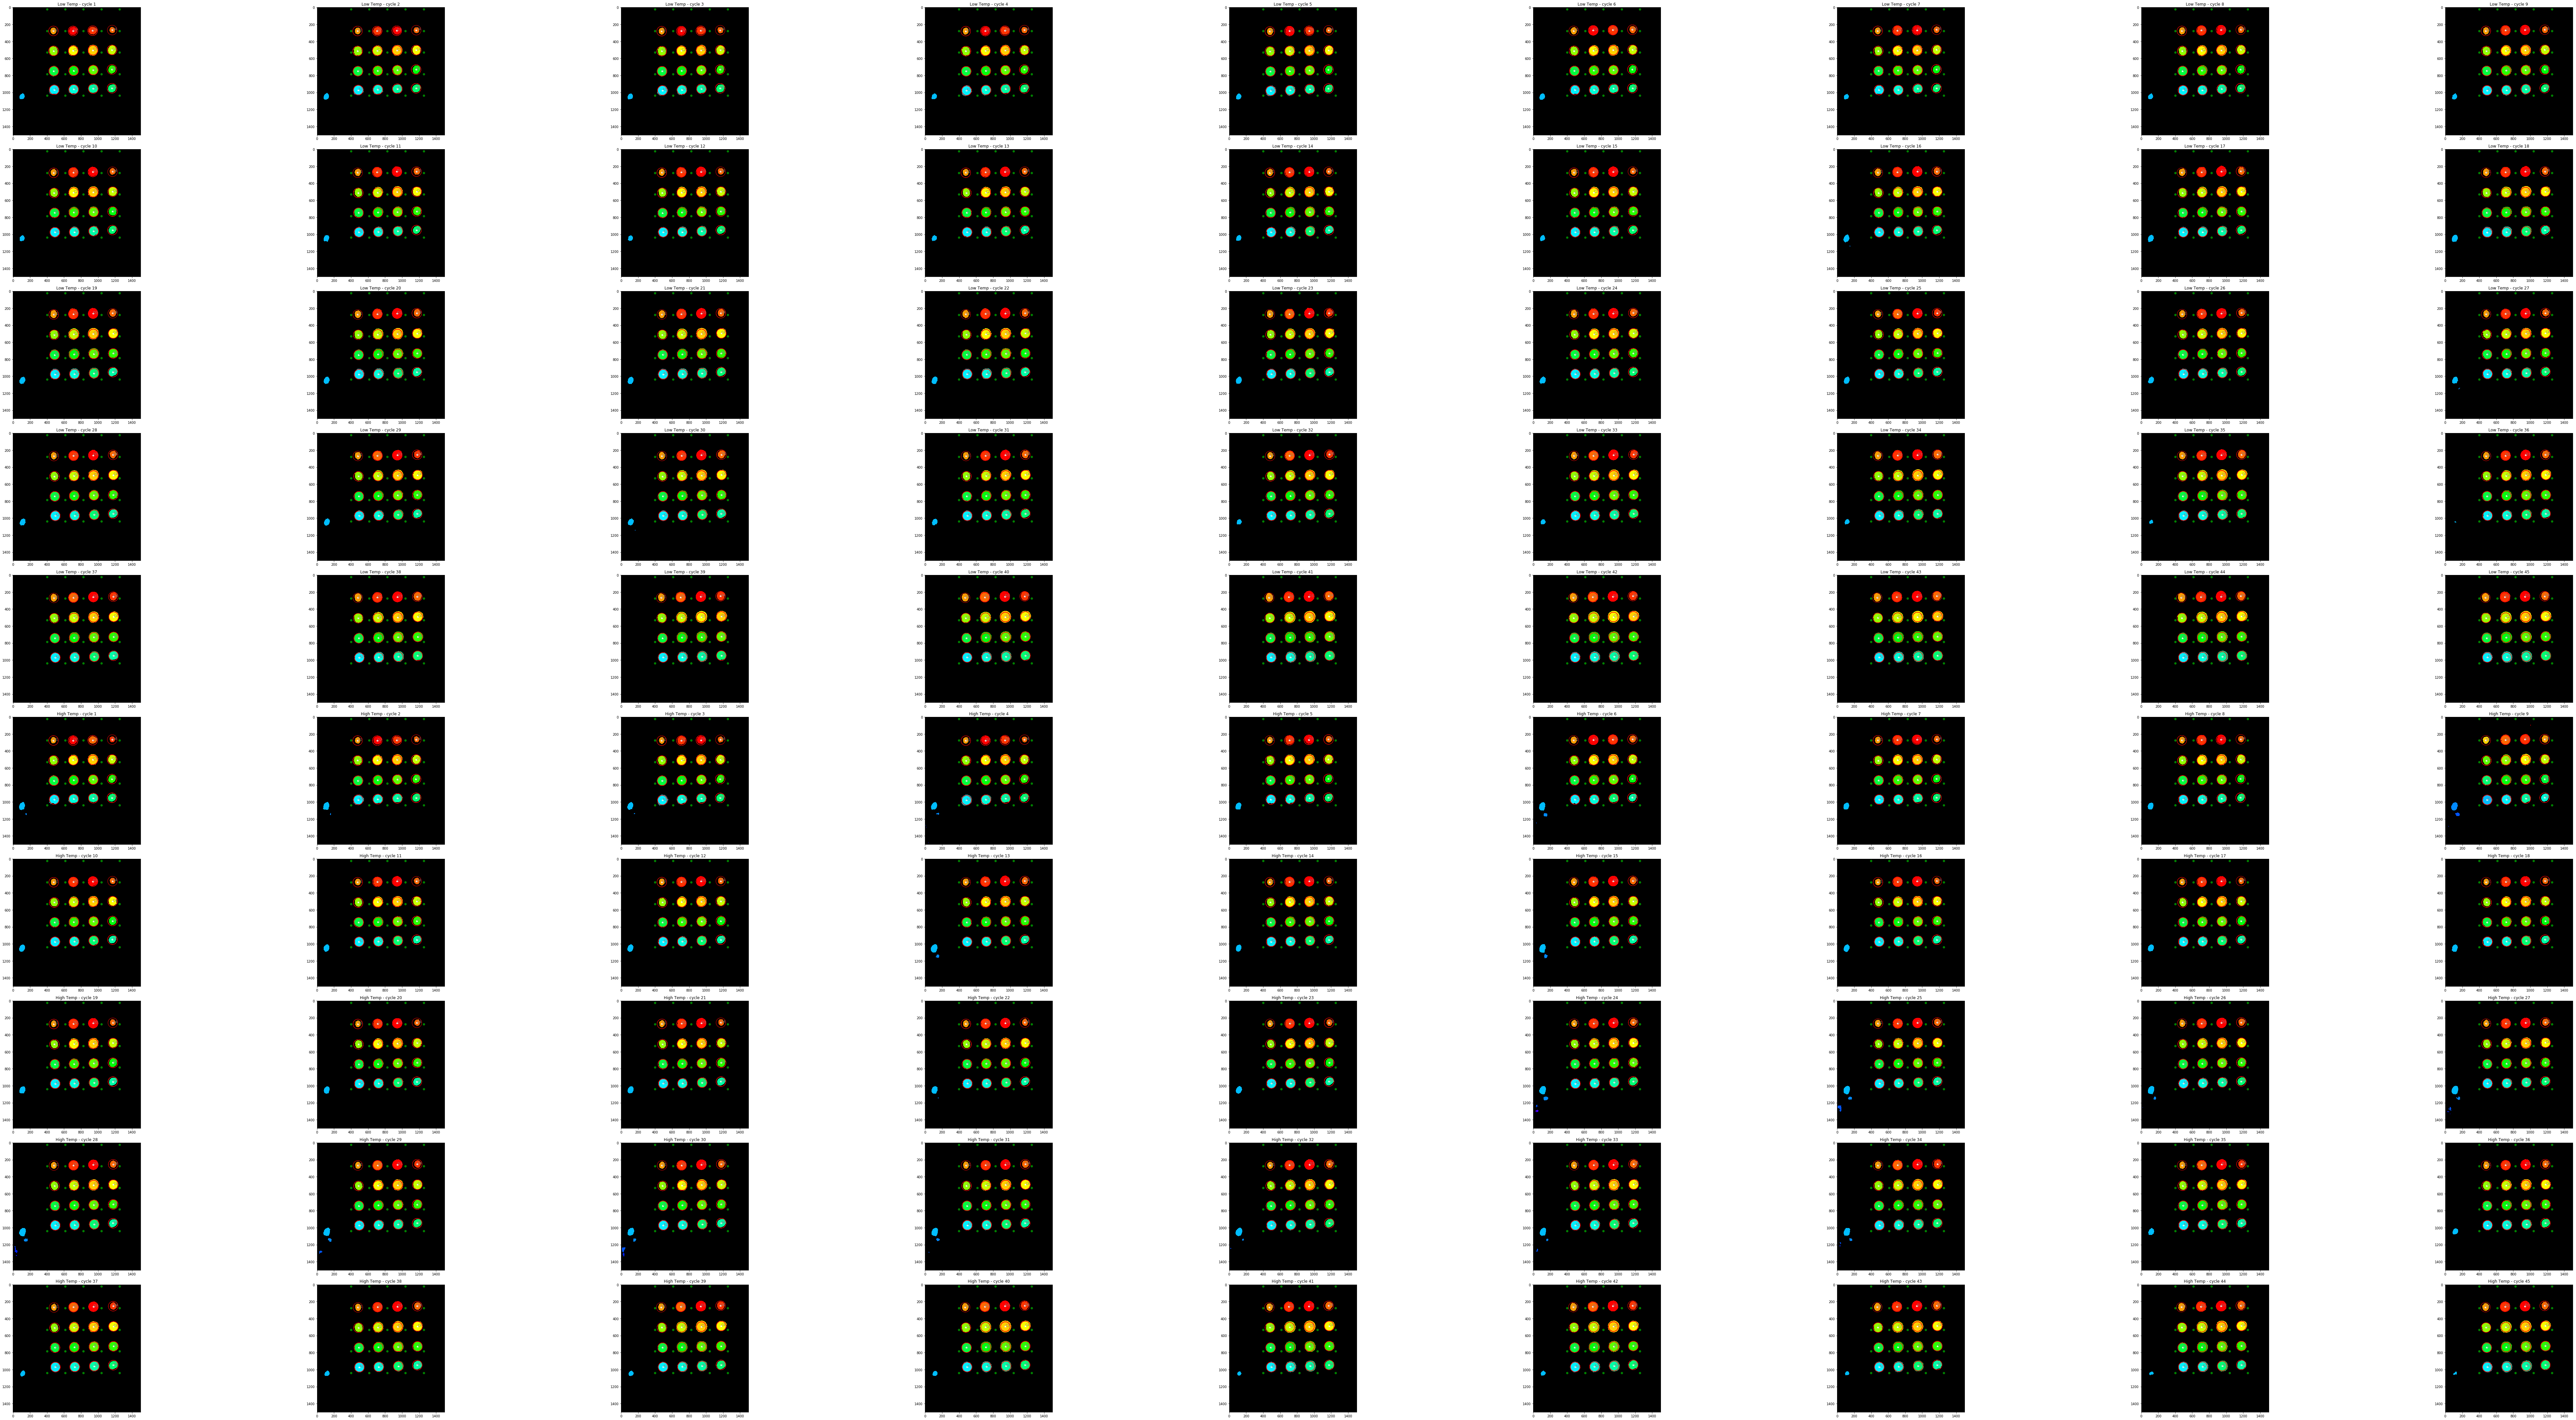

In [26]:
fig, ax = plt.subplots(10, 9, figsize=(24*5, 12*5))            
region_intensity_dict = {}
for t in range(2):
    region_intensity_dict[temp_li[t]] = {}
    for well in well_location_dict.keys():
        region_intensity_dict[temp_li[t]][well] = [0]*45
        
    for c in range(45):
        im_labeled = im_dict['Q670'][temp_li[t]][c]['labeled']
        image_label_overlay = skimage.color.label2rgb(im_labeled, bg_label=0, colors=colors_li)
        ax_x_coord = c//9+(t*5)
        ax_y_coord = c%9
        
        ax[ax_x_coord, ax_y_coord].imshow(image_label_overlay)
        ax[ax_x_coord, ax_y_coord].set_title(f'{temp_li[t]} - cycle {c+1}')
        ax[ax_x_coord, ax_y_coord].scatter(pts_x, pts_y, c='g')
        
        sorted_region_key = list(im_dict['Q670'][temp_li[t]][c]['regions'].keys())
        sorted_region_key.sort(reverse=True)
                
        center_at_cycle = {}
        circle_li = []
        for key in sorted_region_key:
            region_obj = im_dict['Q670'][temp_li[t]][c]['regions'][key]
            y, x = region_obj.centroid
            grid = get_grid_loc(x, y, result_dict['well_grid'][temp_li[t]]['Q670'])
            if grid is None:
                continue
            
            if grid not in center_at_cycle.keys():
                center = [x, y]
                center_at_cycle[grid] = center

                y_min, x_min, y_max, x_max = well_location_dict[grid]
                grid_center_x = (x_max-x_min)/2 + x_min
                rad = grid_center_x - x_min - 50
                circle_li.append(_patches.Circle(center, radius=rad, color='r', fill=False, linewidth=1))
            else:
                center = center_at_cycle[grid]
            well = get_well_loc(x, y, center, result_dict['well_grid'][temp_li[t]]['Q670'])

            if well is not None:
                val = region_intensity_dict[temp_li[t]][well][c]
                val += region_obj.intensity_image.sum()
                region_intensity_dict[temp_li[t]][well][c] = val

                ax[ax_x_coord, ax_y_coord].plot(x, y, color='white', marker='*')
                ax[ax_x_coord, ax_y_coord].text(x, y, well, color='gray')
            else:
                ax[ax_x_coord, ax_y_coord].plot(x, y, color='b', marker='x')
            for circle in circle_li:
                ax[ax_x_coord, ax_y_coord].add_artist(circle)

plt.tight_layout()
plt.savefig('hsv_otsu_camera2_q670_circle.png')
plt.show()

In [27]:
df_high_q = pd.DataFrame(region_intensity_dict['High Temp'])

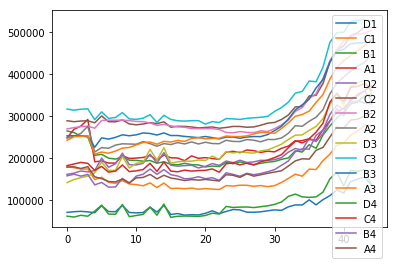

In [28]:
pd.DataFrame(region_intensity_dict['High Temp']).plot()

In [29]:
df_before = dict_before['qua72']
df_before.columns = col_li
df_before.index = range(1, len(df_before)+1)

In [30]:
df_high_q.index = range(1, 46)
df_high_q = df_high_q.reindex(sorted(df_high_q.columns), axis=1)

df_before_norm = (df_before - df_before.loc[10:20].mean())/(df_before.max()-df_before.loc[10:20].mean())
df_high_q_norm = (df_high_q-df_high_q.loc[10:20].mean())/(df_high_q.max()-df_high_q.loc[10:20].mean())

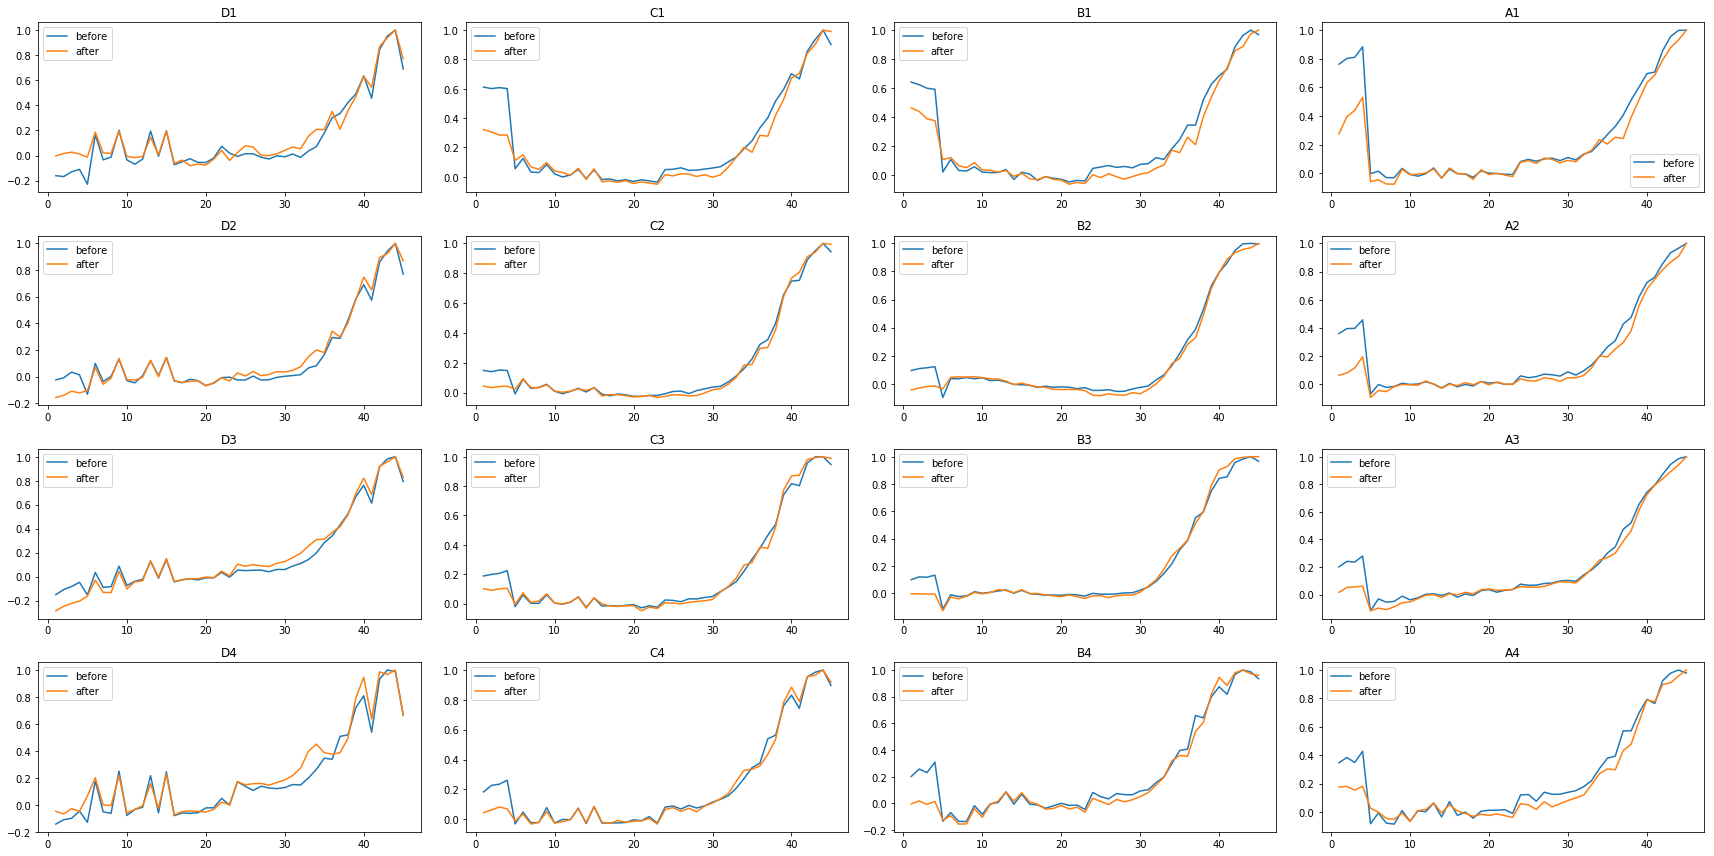

In [31]:
fig, axes = plt.subplots(4, 4, figsize=(24, 12))
n = 0
for col in df_before_norm.columns:
    i = n%4
    j = n//4
    axes[i, j].plot(df_before_norm[col], label='before')
    axes[i, j].plot(df_high_q_norm[col], label='after')
    axes[i, j].set_title(col)
    n += 1
    axes[i, j].legend(loc='best')
plt.tight_layout()
plt.show()

# Low Cal Red

In [23]:
pts_x = []
pts_y = []
for key, val in result_dict['well_grid'].items():
    y1, x1, y2, x2 = val
    pts_x.extend([x1, x2])
    pts_y.extend([y1, y2])

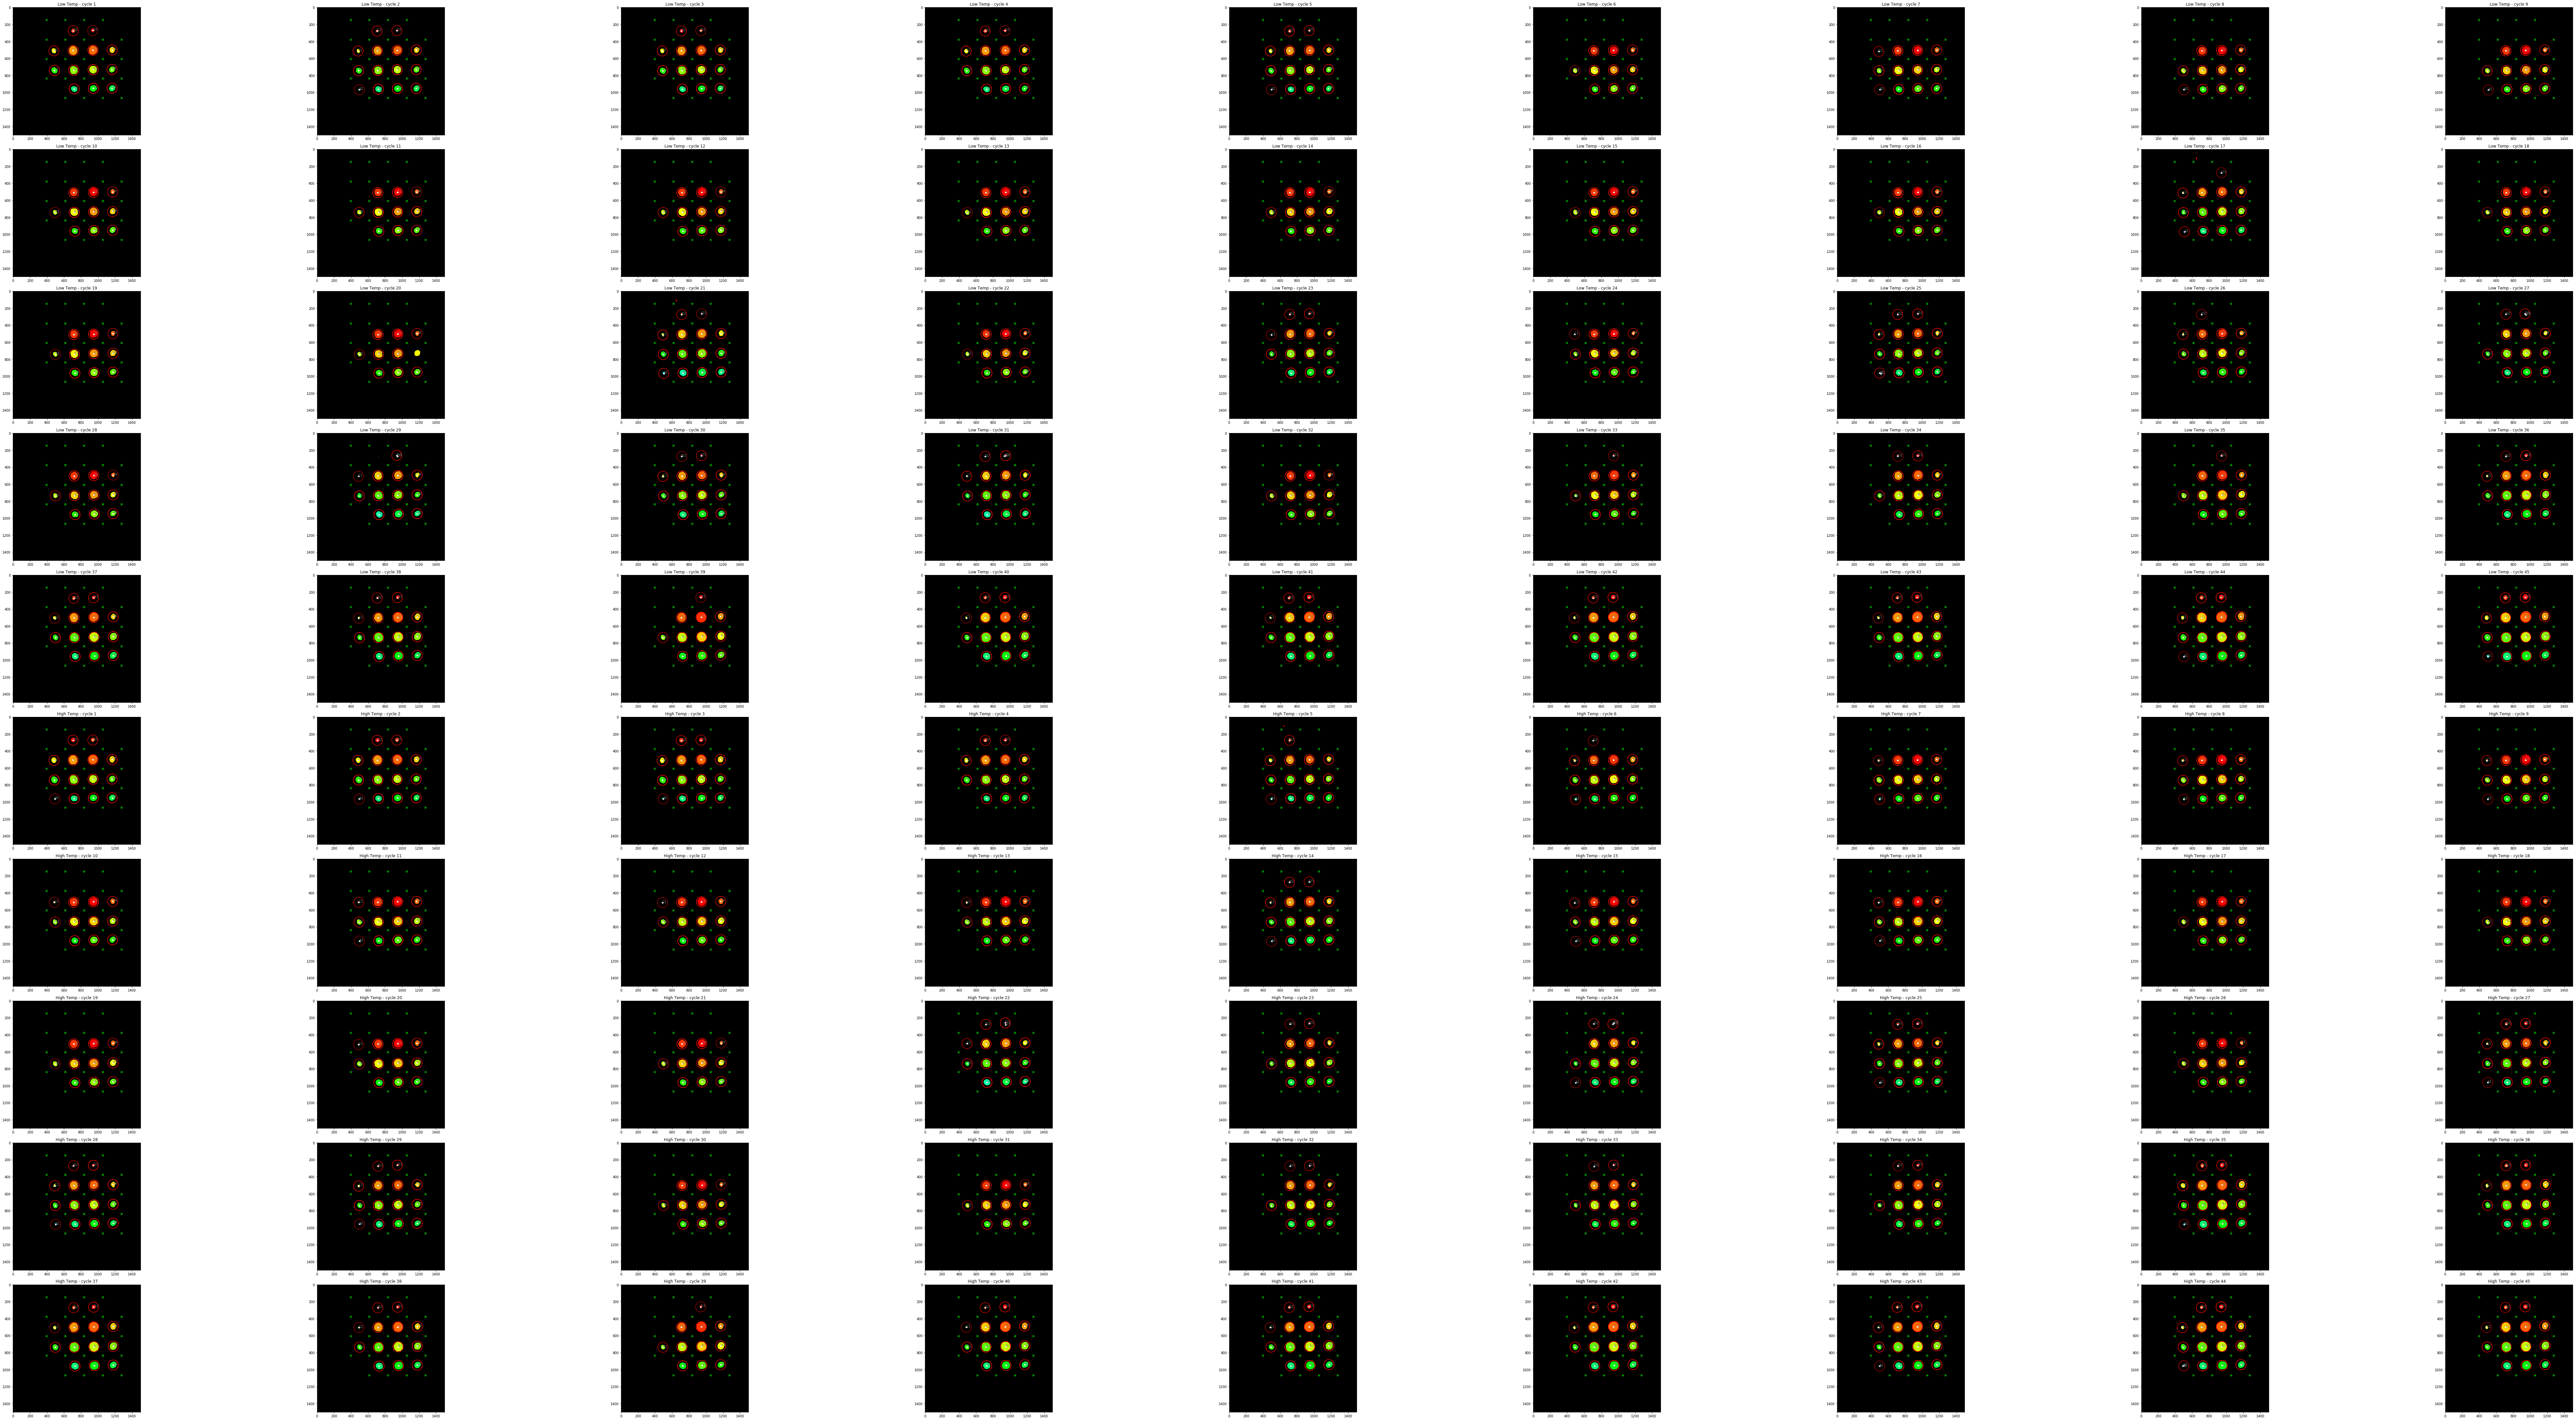

In [24]:
fig, ax = plt.subplots(10, 9, figsize=(24*5, 12*5))            
region_intensity_dict = {}
for t in range(2):
    region_intensity_dict[temp_li[t]] = {}
    for well in well_location_dict.keys():
        region_intensity_dict[temp_li[t]][well] = [0]*45

    for c in range(45):
        im_labeled = im_dict['CalRed'][temp_li[t]][c]['labeled']
        image_label_overlay = skimage.color.label2rgb(im_labeled, bg_label=0, colors=colors_li)
        ax_x_coord = c//9+(t*5)
        ax_y_coord = c%9

        ax[ax_x_coord, ax_y_coord].imshow(image_label_overlay)
        ax[ax_x_coord, ax_y_coord].set_title(f'{temp_li[t]} - cycle {c+1}')
        ax[ax_x_coord, ax_y_coord].scatter(pts_x, pts_y, c='g')

        sorted_region_key = list(im_dict['CalRed'][temp_li[t]][c]['regions'].keys())
        sorted_region_key.sort(reverse=True)

        center_at_cycle = {}
        circle_li = []
        for key in sorted_region_key:
            region_obj = im_dict['CalRed'][temp_li[t]][c]['regions'][key]
            y, x = region_obj.centroid
            grid = get_grid_loc(x, y, result_dict['well_grid'])
            if grid is None:
                continue

            if grid not in center_at_cycle.keys():
                center = [x, y]
                center_at_cycle[grid] = center

                y_min, x_min, y_max, x_max = well_location_dict[grid]
                grid_center_x = (x_max-x_min)/2 + x_min
                rad = grid_center_x - x_min - 50
                circle_li.append(_patches.Circle(center, radius=rad, color='r', fill=False, linewidth=1))
            else:
                center = center_at_cycle[grid]
            well = get_well_loc(x, y, center, result_dict['well_grid'])

            if well is not None:
                val = region_intensity_dict[temp_li[t]][well][c]
                val += region_obj.intensity_image.sum()
                region_intensity_dict[temp_li[t]][well][c] = val

                ax[ax_x_coord, ax_y_coord].plot(x, y, color='white', marker='*')
                ax[ax_x_coord, ax_y_coord].text(x, y, well, color='gray')
            else:
                ax[ax_x_coord, ax_y_coord].plot(x, y, color='b', marker='x')
            for circle in circle_li:
                ax[ax_x_coord, ax_y_coord].add_artist(circle)

plt.tight_layout()
plt.savefig('hsv_otsu_camera2_calRed_circle2.png')
plt.show()

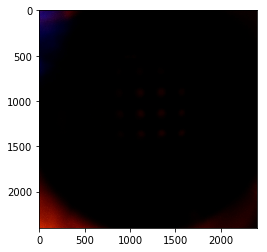

In [35]:
fpath = im_dir/'7_0_0.jpg'
im = np.array(Image.open(fpath))
plt.imshow(im)

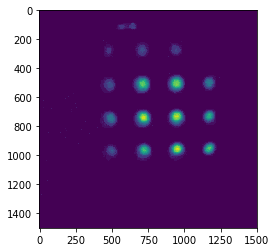

In [36]:
im_cropped = im[x_range, y_range]

im_hsv = cv2.cvtColor(im_cropped, cv2.COLOR_BGR2HSV)
im_gray = im_hsv[:, :, 2]
plt.imshow(im_gray)

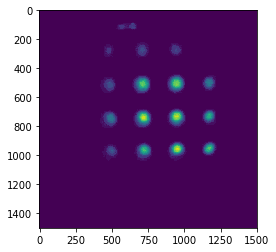

In [37]:
im_cropped = im[x_range, y_range]
plt.imshow(im_cropped[:, :, 0])

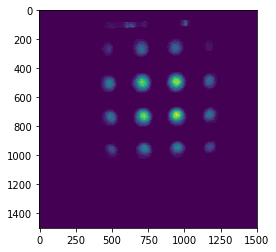

In [44]:
plt.imshow(im_gray)

In [46]:
otsu = skimage.filters.threshold_otsu(im_gray)
mean = skimage.filters.threshold_mean(im_gray)
print(otsu, mean)

8 0.6751333333333334


(array([2.055567e+06, 0.000000e+00, 3.022000e+04, 0.000000e+00,
        3.492100e+04, 0.000000e+00, 0.000000e+00, 1.213600e+04,
        0.000000e+00, 7.847000e+03, 0.000000e+00, 0.000000e+00,
        1.543400e+04, 0.000000e+00, 1.165400e+04, 0.000000e+00,
        0.000000e+00, 1.009700e+04, 0.000000e+00, 8.165000e+03,
        0.000000e+00, 5.290000e+03, 0.000000e+00, 0.000000e+00,
        5.145000e+03, 0.000000e+00, 6.450000e+03, 0.000000e+00,
        0.000000e+00, 6.875000e+03, 0.000000e+00, 5.611000e+03,
        0.000000e+00, 0.000000e+00, 4.745000e+03, 0.000000e+00,
        3.541000e+03, 0.000000e+00, 0.000000e+00, 2.464000e+03,
        0.000000e+00, 2.209000e+03, 0.000000e+00, 2.274000e+03,
        0.000000e+00, 0.000000e+00, 1.859000e+03, 0.000000e+00,
        1.582000e+03, 0.000000e+00, 0.000000e+00, 1.050000e+03,
        0.000000e+00, 1.029000e+03, 0.000000e+00, 0.000000e+00,
        1.120000e+03, 0.000000e+00, 1.120000e+03, 0.000000e+00,
        1.366000e+03, 0.000000e+00, 0.00

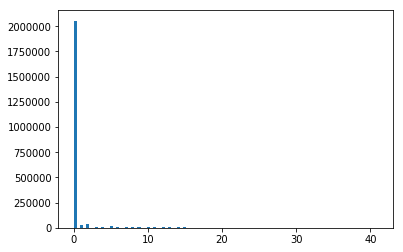

In [54]:
plt.hist(im_gray.ravel(), bins=100)

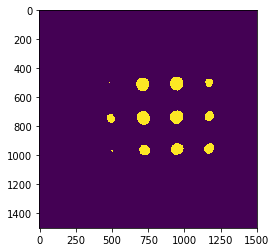

In [38]:
plt.imshow(im_dict['CalRed'][temp_li[0]][7]['thresh'])

# High HEX

In [64]:
pts_low_x = []
pts_low_y = []
for key, val in result_dict['well_grid']['Low Temp']['HEX'].items():
    y1, x1, y2, x2 = val
    pts_low_x.extend([x1, x2])
    pts_low_y.extend([y1, y2])
pts_high_x = []
pts_high_y = []
for key, val in result_dict['well_grid']['High Temp']['HEX'].items():
    y1, x1, y2, x2 = val
    pts_high_x.extend([x1, x2])
    pts_high_y.extend([y1, y2])
pts_x = [pts_low_x, pts_high_x]
pts_y = [pts_low_y, pts_high_y]

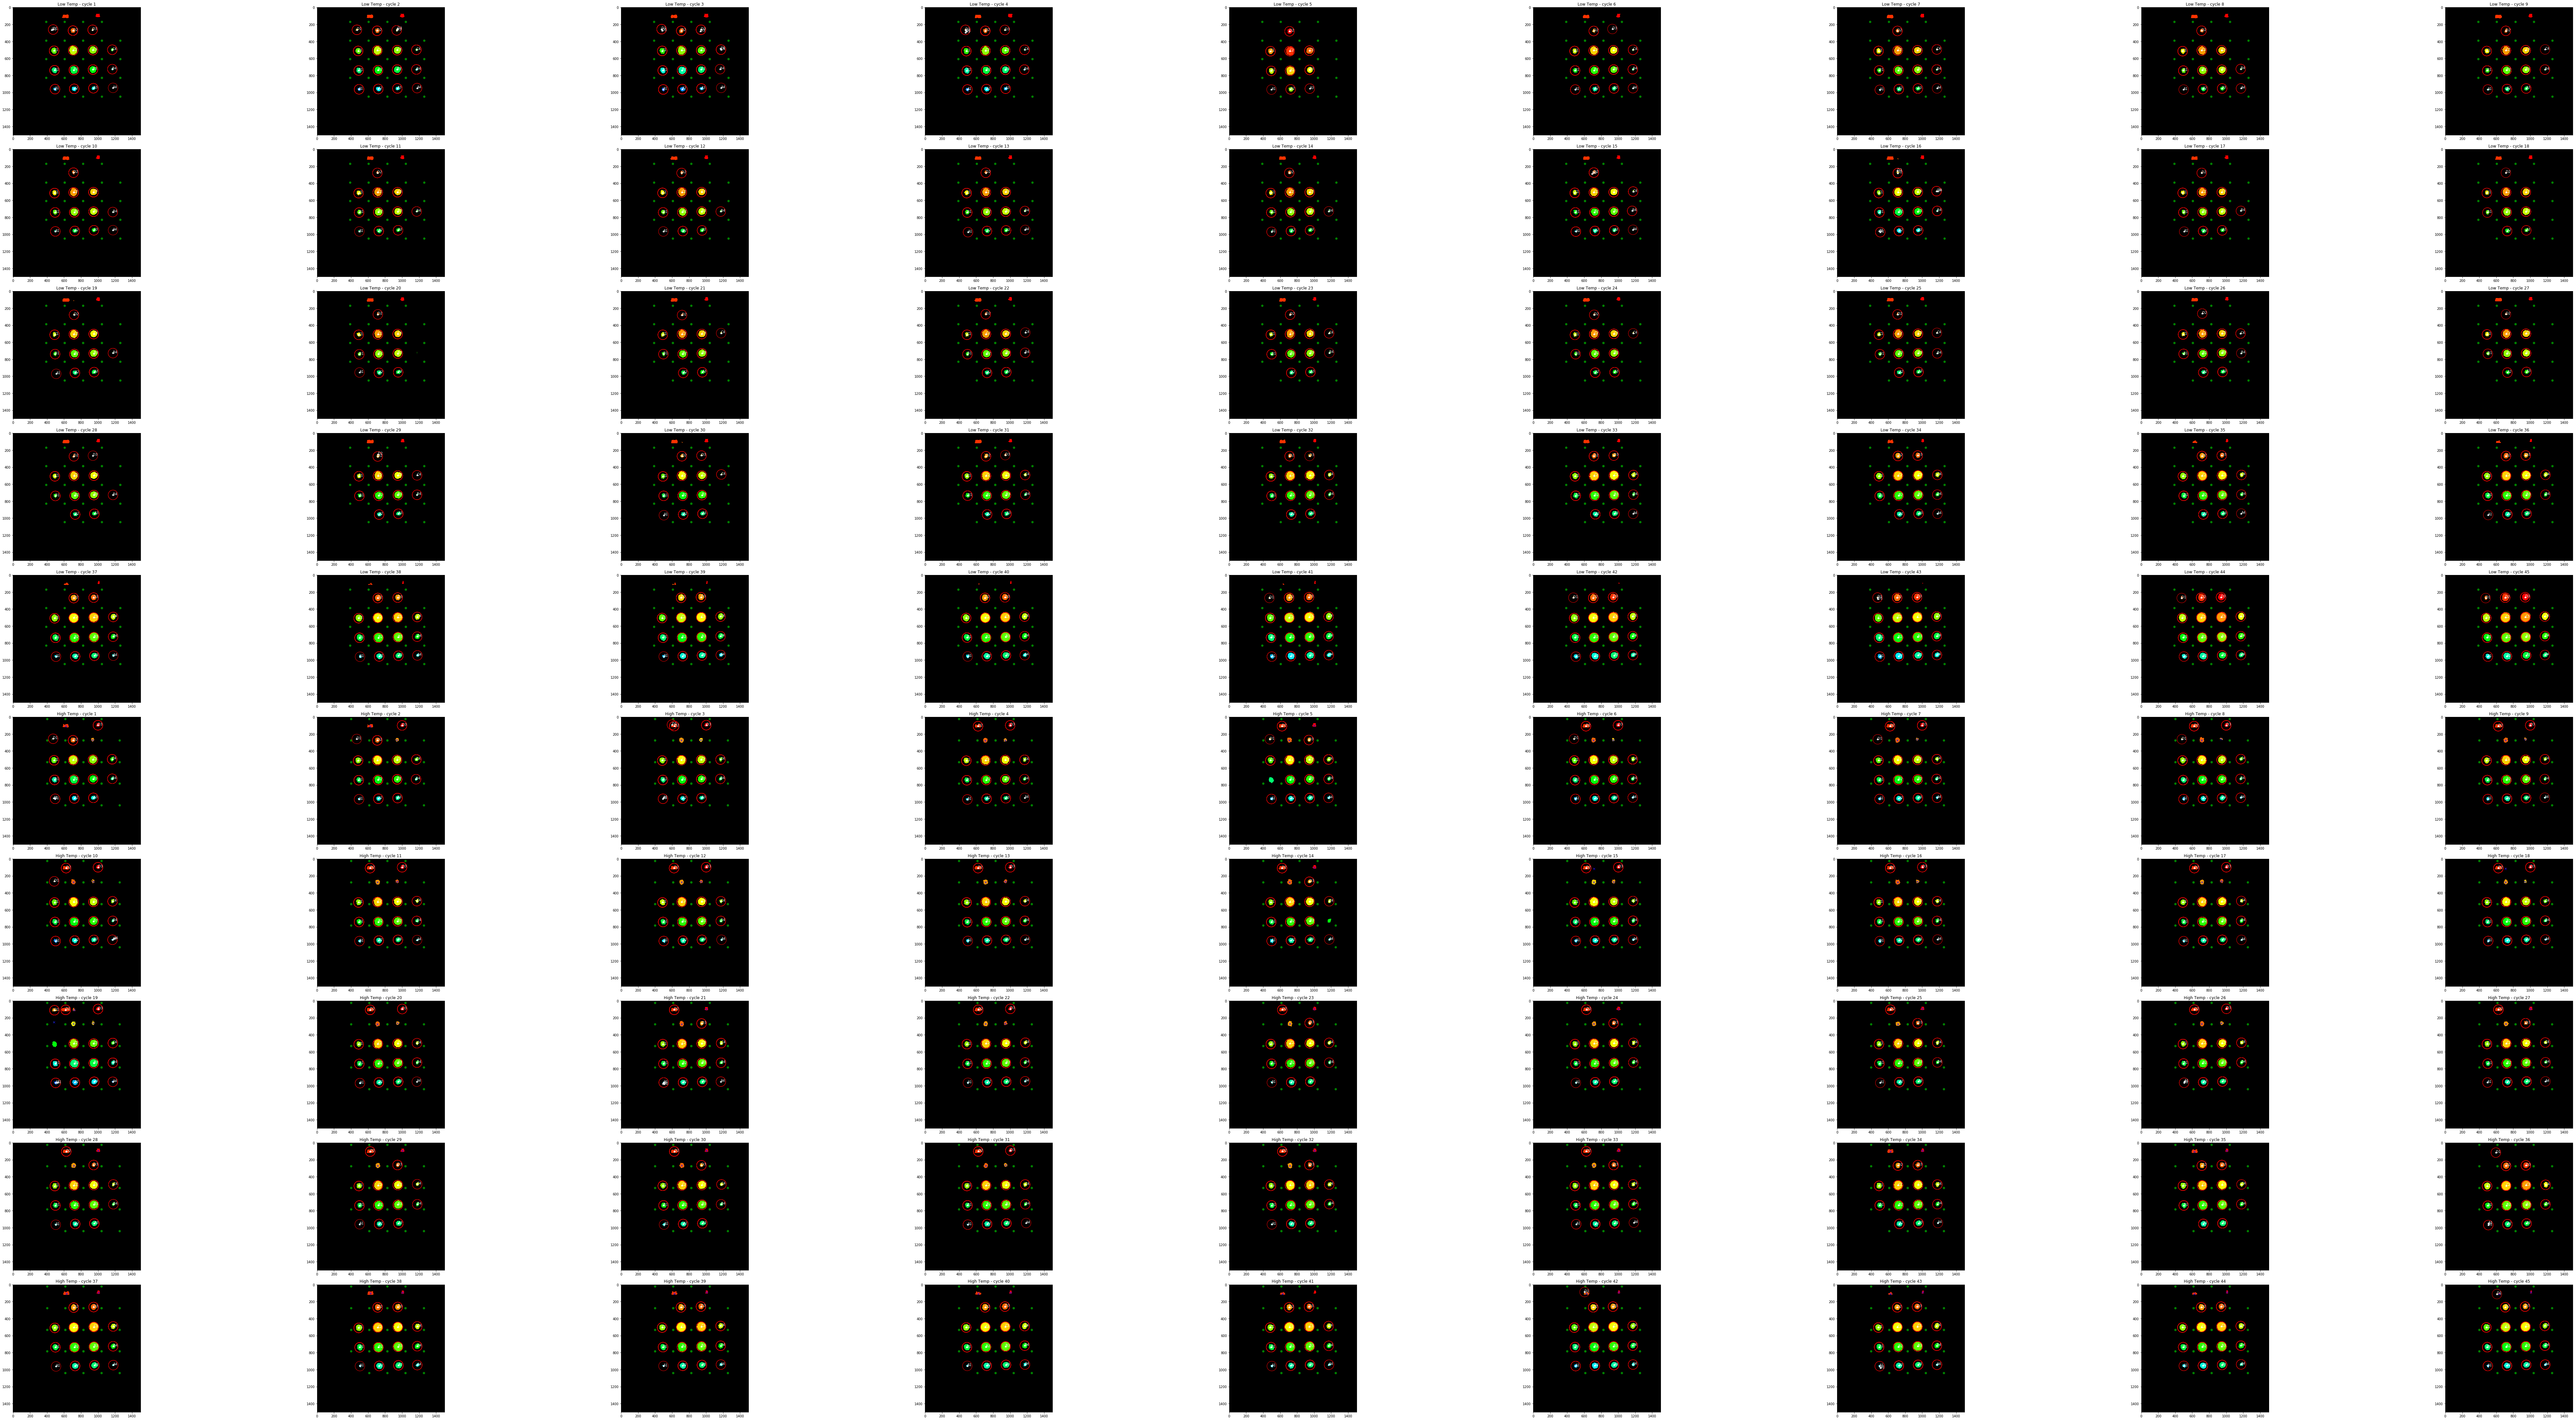

In [65]:
fig, ax = plt.subplots(10, 9, figsize=(24*5, 12*5))            
region_intensity_dict = {}
for t in range(2):
    region_intensity_dict[temp_li[t]] = {}
    for well in well_location_dict.keys():
        region_intensity_dict[temp_li[t]][well] = [0]*45
        
    for c in range(45):
        im_labeled = im_dict['HEX'][temp_li[t]][c]['labeled']
        image_label_overlay = skimage.color.label2rgb(im_labeled, bg_label=0, colors=colors_li)
        ax_x_coord = c//9+(t*5)
        ax_y_coord = c%9
        
        ax[ax_x_coord, ax_y_coord].imshow(image_label_overlay)
        ax[ax_x_coord, ax_y_coord].set_title(f'{temp_li[t]} - cycle {c+1}')
        ax[ax_x_coord, ax_y_coord].scatter(pts_x[t], pts_y[t], c='g')
        
        sorted_region_key = list(im_dict['HEX'][temp_li[t]][c]['regions'].keys())
        sorted_region_key.sort(reverse=True)
                
        center_at_cycle = {}
        circle_li = []
        for key in sorted_region_key:
            region_obj = im_dict['HEX'][temp_li[t]][c]['regions'][key]
            y, x = region_obj.centroid
            grid = get_grid_loc(x, y, result_dict['well_grid'][temp_li[t]]['HEX'])
            if grid is None:
                continue
            
            if grid not in center_at_cycle.keys():
                center = [x, y]
                center_at_cycle[grid] = center

                y_min, x_min, y_max, x_max = well_location_dict[grid]
                grid_center_x = (x_max-x_min)/2 + x_min
                rad = grid_center_x - x_min - 50
                circle_li.append(_patches.Circle(center, radius=rad, color='r', fill=False, linewidth=1))
            else:
                center = center_at_cycle[grid]
            well = get_well_loc(x, y, center, result_dict['well_grid'][temp_li[t]]['HEX'])

            if well is not None:
                val = region_intensity_dict[temp_li[t]][well][c]
                val += region_obj.intensity_image.sum()
                region_intensity_dict[temp_li[t]][well][c] = val

                ax[ax_x_coord, ax_y_coord].plot(x, y, color='white', marker='*')
                ax[ax_x_coord, ax_y_coord].text(x, y, well, color='white')
            else:
                ax[ax_x_coord, ax_y_coord].plot(x, y, color='b', marker='x')
            for circle in circle_li:
                ax[ax_x_coord, ax_y_coord].add_artist(circle)

plt.tight_layout()
plt.savefig('hsv_otsu_camera2_HEX_circle.png')
plt.show()

In [60]:
get_grid_loc(626, 104, result_dict['well_grid'][temp_li[1]]['HEX'])

'D2'

In [61]:
result_dict['well_grid'][temp_li[1]]['HEX']

{'D1': [22.0, 399.0, 276.0, 612.75],
 'C1': [276.0, 399.0, 530.0, 612.75],
 'B1': [530.0, 399.0, 784.0, 612.75],
 'A1': [784.0, 399.0, 1038.0, 612.75],
 'D2': [22.0, 612.75, 276.0, 826.5],
 'C2': [276.0, 612.75, 530.0, 826.5],
 'B2': [530.0, 612.75, 784.0, 826.5],
 'A2': [784.0, 612.75, 1038.0, 826.5],
 'D3': [22.0, 826.5, 276.0, 1040.25],
 'C3': [276.0, 826.5, 530.0, 1040.25],
 'B3': [530.0, 826.5, 784.0, 1040.25],
 'A3': [784.0, 826.5, 1038.0, 1040.25],
 'D4': [22.0, 1040.25, 276.0, 1254.0],
 'C4': [276.0, 1040.25, 530.0, 1254.0],
 'B4': [530.0, 1040.25, 784.0, 1254.0],
 'A4': [784.0, 1040.25, 1038.0, 1254.0]}

In [57]:
fpath = im_dir/'18_1_3.jpg'
im = np.array(Image.open(fpath))

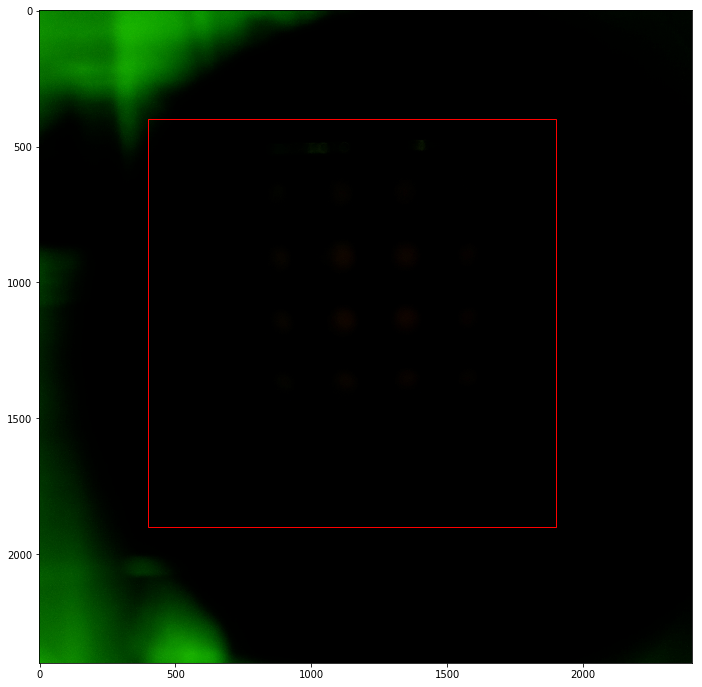

In [58]:
rect = _patches.Rectangle((400, 400), 1500, 1500,linewidth=1,edgecolor='r',facecolor='none')
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(im)
ax.add_patch(rect)

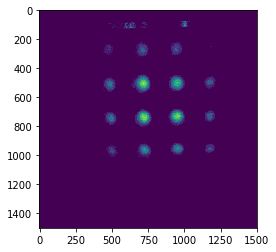

In [41]:
im_cropped = im[x_range, y_range]
plt.imshow(im_cropped[:, :, 0])